# Importing Libraries


In [1]:
import pandas as pd
import itertools
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', None)

# Importing and Preprocessing dataset

In [2]:
df=pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [3]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df.condition.value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [5]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')|(df['condition']=='Insomnia')|(df['condition']=='Obesity')]

In [6]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

In [7]:
X.head()

,condition,review
2,Birth Control,"""I used to take another oral contraceptive, wh..."
3,Birth Control,"""This is my first time using any form of birth..."
9,Birth Control,"""I had been on the pill for many years. When m..."
11,Depression,"""I have taken anti-depressants for years, with..."
14,Birth Control,"""Started Nexplanon 2 months ago because I have..."


In [8]:
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

In [9]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [10]:
pd.set_option('max_colwidth', -1)

<ipython-input-10-7020dba1819a>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [11]:
X.head()

,condition,review
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger."
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."
14,Birth Control,"Started Nexplanon 2 months ago because I have a minimal amount of contraception&#039;s I can take due to my inability to take the hormone that is used in most birth controls. I&#039;m trying to give it time because it is one of my only options right now. But honestly if I had options I&#039;d get it removed.\r\nI&#039;ve never had acne problems in my life, and immediately broke out after getting it implanted. Sex drive is completely gone, and I used to have sex with my boyfriend a few days a week, now its completely forced and not even fun for me anymore. I mean I&#039;m on birth control because I like having sex but don&#039;t want to get pregnant, why take a birth control that takes away sex? Very unhappy and hope that I get it back with time or I&#039;m getting it removed."


In [12]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re

In [14]:
def review_to_words(raw_review): 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stop]
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    return( ' '.join(lemmitize_words))

In [15]:
nltk.download('wordnet')
X['review_clean'] = X['review'].apply(review_to_words)

[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-14-185776880d18>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [16]:
X.head()

,condition,review,review_clean
2,Birth Control,"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas.",used take another oral contraceptive pill cycle happy light period max day side effect contained hormone gestodene available u switched lybrel ingredient similar pill ended started lybrel immediately first day period instruction said period lasted two week taking second pack two week third pack thing got even worse third period lasted two week end third week still daily brown discharge positive side side effect idea period free tempting ala
3,Birth Control,"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch",first time using form birth control glad went patch month first decreased libido subsided downside made period longer day exact used period day max also made cramp intense first two day period never cramp using birth control happy patch
9,Birth Control,"I had been on the pill for many years. When my doctor changed my RX to chateal, it was as effective. It really did help me by completely clearing my acne, this takes about 6 months though. I did not gain extra weight, or develop any emotional health issues. I stopped taking it bc I started using a more natural method of birth control, but started to take it bc I hate that my acne came back at age 28. I really hope symptoms like depression, or weight gain do not begin to affect me as I am older now. I&#039;m also naturally moody, so this may worsen things. I was in a negative mental rut today. Also I hope this doesn&#039;t push me over the edge, as I believe I am depressed. Hopefully it&#039;ll be just like when I was younger.",pill many year doctor changed rx chateal effective really help completely clearing acne take month though gain extra weight develop emotional health issue stopped taking bc started using natural method birth control started take bc hate acne came back age really hope symptom like depression weight gain begin affect older also naturally moody may worsen thing negative mental rut today also hope push edge believe depressed hopefully like younger
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect
14,Birth Control,"Started Nexplanon 2 months ago because I have a minim

# Creating features and Target variables

In [17]:
X_feat=X['review_clean']
y=X['condition']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# LSTM


Epoch 1/10
625/625 [==============================] - 275s 434ms/step - loss: 0.4517 - accuracy: 0.8413 - val_loss: 0.2724 - val_accuracy: 0.9102
Epoch 2/10
625/625 [==============================] - 261s 418ms/step - loss: 0.1418 - accuracy: 0.9575 - val_loss: 0.1928 - val_accuracy: 0.9505
Epoch 3/10
625/625 [==============================] - 262s 419ms/step - loss: 0.1007 - accuracy: 0.9694 - val_loss: 0.1278 - val_accuracy: 0.9605
Epoch 4/10
625/625 [==============================] - 264s 423ms/step - loss: 0.0699 - accuracy: 0.9787 - val_loss: 0.1304 - val_accuracy: 0.9605
Epoch 5/10
625/625 [==============================] - 266s 425ms/step - loss: 0.0582 - accuracy: 0.9819 - val_loss: 0.1926 - val_accuracy: 0.9483
Epoch 6/10
625/625 [==============================] - 260s 417ms/step - loss: 0.0503 - accuracy: 0.9852 - val_loss: 0.1165 - val_accuracy: 0.9679
Epoch 7/10
625/625 [==============================] - 260s 416ms/step - loss: 0.0388 - accuracy: 0.9881 - val_loss: 0.1206 -

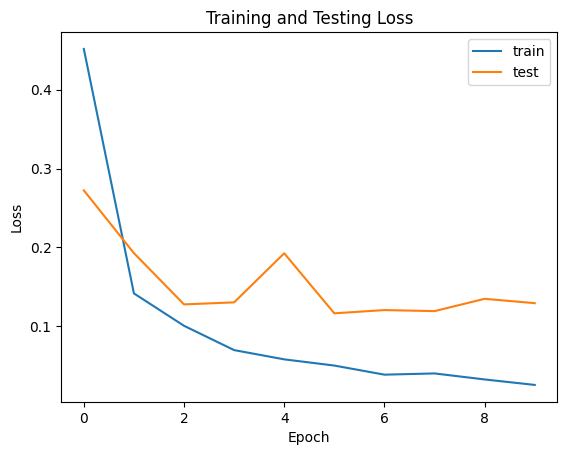

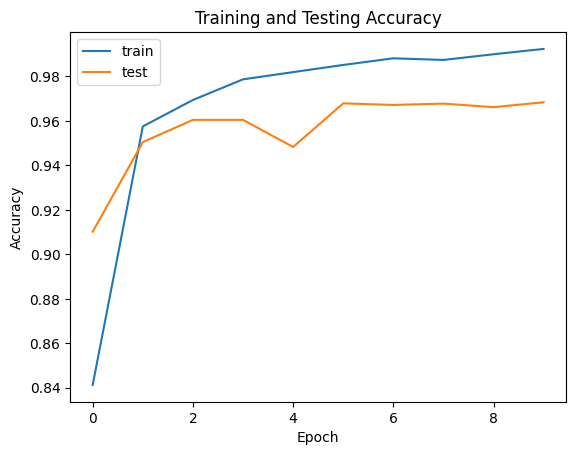

313/313 [==============================] - 14s 43ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5758
           1       0.93      0.95      0.94      1814
           2       0.94      0.93      0.94       511
           3       0.93      0.89      0.91       464
           4       0.91      0.91      0.91       735
           5       0.94      0.94      0.94       713

    accuracy                           0.97      9995
   macro avg       0.94      0.94      0.94      9995
weighted avg       0.97      0.97      0.97      9995

Confusion matrix, without normalization


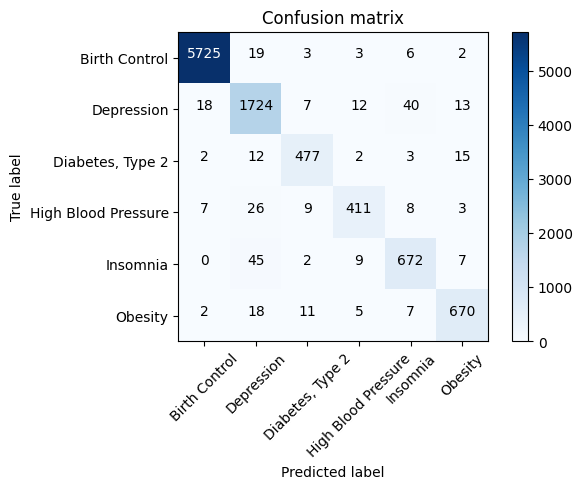

In [30]:
# Importing the necessary libraries
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Creating a tokenizer object
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

# Converting text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding the sequences
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)

# Creating the model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Converting labels to categorical variables
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

# Training the model
history = model.fit(X_train_seq_padded, y_train_encoded, validation_data=(X_test_seq_padded, y_test_encoded), epochs=10, batch_size=64)

# Plotting training and testing loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plotting training and testing accuracy
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Evaluating the model
y_pred = model.predict(X_test_seq_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
print(metrics.classification_report(y_test_classes, y_pred_classes))

# Plotting the confusion matrix
cm = metrics.confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure', 'Insomnia', 'Obesity'])


# Bi LSTM

In [34]:
from keras.layers import Bidirectional

# Creating the model
model = Sequential()
model.add(Embedding(5000, 128, input_length=100))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Training the model
history = model.fit(X_train_seq_padded, y_train_encoded, validation_data=(X_test_seq_padded, y_test_encoded), epochs=10, batch_size=64)

Epoch 1/10
625/625 [==============================] - 530s 837ms/step - loss: 0.4789 - accuracy: 0.8330 - val_loss: 0.2052 - val_accuracy: 0.9340
Epoch 2/10
625/625 [==============================] - 542s 867ms/step - loss: 0.1541 - accuracy: 0.9528 - val_loss: 0.1490 - val_accuracy: 0.9529
Epoch 3/10
625/625 [==============================] - 523s 838ms/step - loss: 0.1053 - accuracy: 0.9677 - val_loss: 0.1207 - val_accuracy: 0.9612
Epoch 4/10
625/625 [==============================] - 523s 838ms/step - loss: 0.0702 - accuracy: 0.9782 - val_loss: 0.1156 - val_accuracy: 0.9633
Epoch 5/10
625/625 [==============================] - 518s 829ms/step - loss: 0.0606 - accuracy: 0.9808 - val_loss: 0.1700 - val_accuracy: 0.9433
Epoch 6/10
625/625 [==============================] - 524s 838ms/step - loss: 0.0552 - accuracy: 0.9838 - val_loss: 0.1168 - val_accuracy: 0.9659
Epoch 7/10
625/625 [==============================] - 518s 828ms/step - loss: 0.0378 - accuracy: 0.9885 - val_loss: 0.1226 -

313/313 [==============================] - 25s 80ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5758
           1       0.92      0.97      0.94      1814
           2       0.96      0.87      0.91       511
           3       0.93      0.89      0.91       464
           4       0.93      0.89      0.91       735
           5       0.93      0.94      0.93       713

    accuracy                           0.97      9995
   macro avg       0.94      0.92      0.93      9995
weighted avg       0.97      0.97      0.97      9995



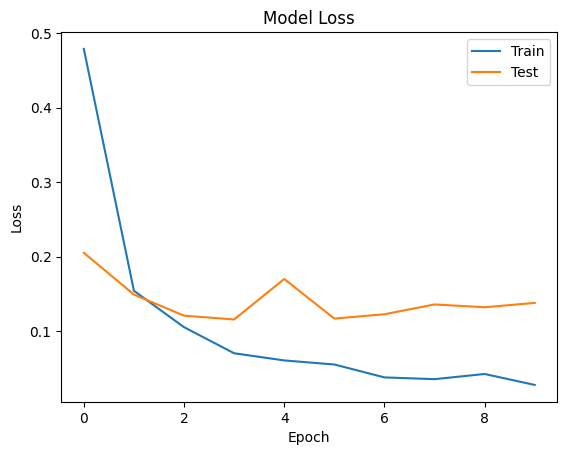

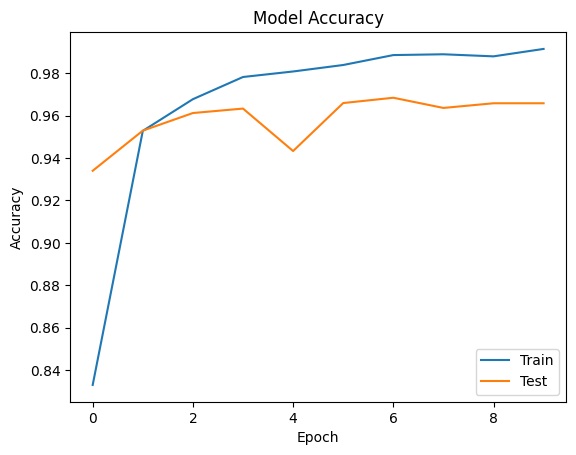

In [37]:
# Evaluating the model
y_pred = model.predict(X_test_seq_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_encoded, axis=1)
print(metrics.classification_report(y_test_classes, y_pred_classes))



# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

Confusion matrix, without normalization


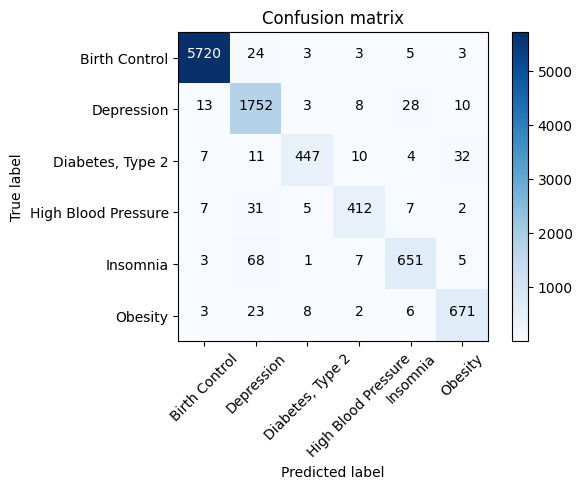

In [38]:
# Plotting the confusion matrix
cm = metrics.confusion_matrix(y_test_classes, y_pred_classes)
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure', 'Insomnia', 'Obesity'])